# Joe Stanley
### ECE 524 - HWK2

Reduce the circuit to a simple RLC system.

In [1]:
# Import Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt
import eepower as eep
from eepower import u, m, k, M

In [2]:
# Define Givens

# Per-Unit Bases
Sbase = 30*M
Vb1 = 138*k
Vb2 = 13.8*k
Vb3 = 4.16*k

# Source
S_src = 3500*M #VA
XR_src = 15 #unitless
V_src = 138*k #V

# Transformer(s)
S_xfm = 30*M #VA
Z_xfm = 7.5/100 #pu
XR_xfm = 18.6 #unitless
V_busA = 13.8*k #V

# Generator
S_gen = 35.3*M #VA
Xdv_gen = 10/100 #pu
XR_gen = 48 #unitless

# Motor Load (each motor)
P_mot = 30000 #hp
Xd_mot = 16.7/100 #pu
XR_mot = 10 #unitless
pf_mot = 0.8 #lagging

# Cap Bank
S_cap = 10*M #VAr

# Load Transformer
S_xfm_ld = 5*M #VA
Z_xfm_ld = 5.5/100 #pu
XR_xfm_ld = 7 #unitless
V_ld = 4.16*k #V

In [69]:
# Define Formulas, Algorithms, and Functions

# Define Impedance From Power and X/R
def zsource(S,V,XoverR,Sbase=None,Vbase=None):
    """
    zsource Function
    
    Used to calculate the source impedance given the apparent power
    magnitude and the X/R ratio.
    
    Parameters
    ----------
    S:          float
                The (rated) apparent power magnitude of the source.
                This may also be refferred to as the "Short-Circuit MVA"
    V:          float
                The (rated) voltage of the source terminals.
    XoverR:     float
                The X/R ratio rated for the source.
    Sbase:      float, optional
                The per-unit base for the apparent power. If set to
                None, will automatically force Sbase to equal S.
                If set to True will treat S as the per-unit value.
    Vbase:      float, optional
                The per-unit base for the terminal voltage. If set to
                None, will automaticlaly force Vbase to equal V. If
                set to True, will treat V as the per-unit value.
    
    Returns
    -------
    Zsource_pu: complex
                The per-unit evaluation of the source impedance.
    """
    # Force Sbase and Vbase if needed
    if Vbase == None:
        Vbase = V
    if Sbase == None:
        Sbase = S
    # Prevent scaling if per-unit already applied
    if Vbase == True:
        Vbase = 1
    if Sbase == True:
        Sbase = 1
    # Set to per-unit
    Spu = S/Sbase
    Vpu = V/Vbase
    # Evaluate Zsource Magnitude
    Zsource_pu = Vpu**2/Spu
    # Evaluate the angle
    nu = np.degrees(np.arctan(XoverR))
    Zsource_pu = eep.phasor(Zsource_pu, nu)
    return(Zsource_pu)

# Define Impedance Decomposer
def zdecompose(Zmag,XoverR):
    """
    zdecompose Function
    
    A function to decompose the impedance magnitude into its
    corresponding resistance and reactance using the X/R ratio.
    
    It is possible to "neglect" R, or make it a very small number;
    this is done by setting the X/R ratio to a very large number
    (X being much larger than R).
    
    Parameters
    ----------
    Zmag:       float
                The magnitude of the impedance.
    XoverR:     float
                The X/R ratio.
    
    Returns
    -------
    R:          float
                The resistance (in ohms)
    X:          float
                The reactance (in ohms)
    """
    # Evaluate Resistance
    R = Zmag/np.sqrt(XoverR**2+1)
    # Evaluate Reactance
    X = R * XoverR
    # Return
    return(R,X)

# Define HP to Watts Calculation
def watts(hp):
    """
    watts Formula
    
    Calculates the power (in watts) given the
    horsepower.
    
    Parameters
    ----------
    hp:         float
                The horspower to compute.
    
    Returns
    watts:      float
                The power in watts.
    """
    return(hp * 745.699872)

# Define Apparent Power to Farad Conversion
def farads(VAR,V,freq=60):
    """
    farads Formula
    
    Function to calculate the required capacitance
    in Farads to provide the desired power rating
    (VARs).
    
    Parameters
    ----------
    VAR:        float
                The rated power to meet.
    V:          float
                The voltage across the capacitor;
                not described as VLL or VLN, merely
                the capacitor voltage.
    freq:       float, optional
                The System frequency
    
    Returns
    -------
    C:          float
                The evaluated capacitance (in Farads).
    """
    return(VAR / (2*np.pi*freq*V**2))

# Define Power Reactance Calculator
def powerimpedance(S,V,parallel=False):
    """
    powerreactance Function
    
    Function to determine the ohmic resistance/reactance
    (impedance) represented by the apparent power (S).
    
    Formula:    Z = V^2 / S           (series components)
                Z = V^2 / (3*S)       (parallel components)
    
    Parameters
    ----------
    S:          complex
                The apparent power of the passive element,
                may be purely resistive or purely reactive.
    V:          float
                The operating voltage of the passive element.
    parallel:   bool, optional
                Control point to specify whether the ohmic
                impedance should be returned as series components
                (False opt.) or parallel components (True opt.).
    
    Returns
    -------
    R:          float
                The ohmic resistance required to consume the
                specified apparent power (S) at the rated
                voltage (V).
    X:          float
                The ohmic reactance required to consume the
                specified apparent power (S) at the rated
                voltage (V).
    """
    # Condition Inputs
    V = abs(V)
    # Test for Parallel Component Option and Evaluate
    if isinstance(S,complex):
        # Complex Power (both R and X)
        if parallel:
            R = V**2 / (3*S.real)
            X = V**2 / (3*S.imag)
        else:
            R = V**2 / (S.real)
            X = V**2 / (S.imag)
        return( R, X )
    # Not Complex (just R)
    R = V**2 / S
    return( R )

In [70]:
# Evaluate Impedance Terms

# Source
Zsrc_pu = zsource(S_src,V_src,XR_src,Sbase,Vb1)
print("Source Impedance:",np.around(Zsrc_pu,4),"pu-ohms")

# Generator
Rgen = Xdv_gen/XR_gen
Zgen = Rgen + 1j*Xdv_gen
Zgen = eep.convert(Zgen,eep.zpu(35.3*M,VLL=13.8*k),eep.zpu(30*M,VLL=13.8*k))
print("Generator Impedance:",np.around(Zgen,4),"pu-ohms")

# Transformer
Rxfm,Xxfm = zdecompose(Z_xfm,XR_xfm)
Zxfm = Rxfm + 1j*Xxfm
print("Transformer Impedance:",np.around(Zxfm,4),"pu-ohms")

Source Impedance: (0.0006+0.0086j) pu-ohms
Generator Impedance: (0.0018+0.085j) pu-ohms
Transformer Impedance: (0.004+0.0749j) pu-ohms


In [71]:
# Base Impedance
Zbase = eep.zpu(Sbase,Vb2)

# Combine impedances into Zeq
Zeq_src = eep.parallelz((Zxfm,Zxfm))+Zsrc_pu
print("Source Zeq:",eep.reactance(Zeq_src*Zbase),"(Ω, H)")
print("Generator Z:",eep.reactance(Zgen*Zbase),"(Ω, H)")
#         Parallel(       Parallel( Trans1, Trans2)+Source, Generator )
Zeq_pu = eep.parallelz((Zeq_src,Zgen))

# Return to actual impedance (in ohms)
Zeq = Zeq_pu*Zbase
print("Thevenin RLC:",Zeq,"Ω")
print("Thevenin RLC:",eep.reactance(Zeq),"(Ω, H)")

# Demonstrate LC system, Neglecting R
print("Thevenin LC:",Zeq.imag,"ohms")
print("Thevenin LC:",eep.reactance(Zeq.imag*1j),"H")

Source Zeq: (0.01639932457188166, 0.0007757683248616666) (Ω, H)
Generator Z: (0.011239376770538243, 0.0014313524185196062) (Ω, H)
Thevenin RLC: (0.008287983107519964+0.1895092011808514j) Ω
Thevenin RLC: (0.008287983107519964, 0.0005031692747875754) (Ω, H)
Thevenin LC: 0.1895092011808514 ohms
Thevenin LC: 0.0005026887688221492 H


In [72]:
# Evaluate Motor Systems

# Find wattage of motor
P_mtr = watts(P_mot)
print("Motor Power:",P_mtr/M,"MW")
S_mtr = P_mtr/pf_mot
Q_mtr = np.sqrt(S_mtr**2 - P_mtr**2)
print("Motor Apparent Power:",S_mtr/M,"MVA")

# Find Impedance
R_mtr = powerimpedance(P_mtr,Vb2)
XL_mtr = powerimpedance(Q_mtr,Vb2)
X_mtr = eep.reactance(XL_mtr)
print("Motor Resistance:",R_mtr,"Ω")
print("Motor Inductace:",X_mtr*k,"mH")

# Calculate Current Magnitude
Imag_mtr = S_mtr/Vb2
print("Motor Current:",Imag_mtr,"A (each)")

# Evaluate Motor's Internal Voltage
# Use basic ohm's law
V_bus = 13.8*k
XL = Zmtr.imag * Zbase
Vmtr = V_bus - XL*Imag_mtr
print("Motor Internal Voltage:",Vmtr,"V")

Motor Power: 22.37099616 MW
Motor Apparent Power: 27.963745199999998 MVA
Motor Resistance: 8.51280821998049 Ω
Motor Inductace: 30.10790017340476 mH
Motor Current: 2026.3583478260869 A (each)
Motor Internal Voltage: 11651.825093736 V


In [64]:
# Evaluate Non-Linear Load

# Transformer
Rxfm,Xxfm = zdecompose(Z_xfm_ld,XR_xfm_ld)
Zxfm_ld = Rxfm + 1j*Xxfm
Zxfm_ld *= Zbase
print("Load Transformer Impedance:",Zxfm_ld,"Ω")
print("Load Transformer Inductance:",eep.reactance(Zxfm_ld.imag)*k,"mH")

# Find Current
P_nll = 4.5*M
I_nll = P_nll / Vb2
print("Non-Linear Load Current Mag.:",I_nll,"A")

# Find Resistance
R_nll = Vb2 / I_nll
print("Non-Linear Load Resistance:",R_nll,"Ω")

Load Transformer Impedance: (0.04937585231669424+0.3456309662168596j) Ω
Load Transformer Inductance: 0.916814612650685 mH
Non-Linear Load Current Mag.: 326.0869565217391 A
Non-Linear Load Resistance: 42.32 Ω


In [32]:
# Determine Cap-Bank Capacitance in Farads
Vcap = eep.phaseline(VLL=13.8*k)
print("Voltage Across one Capacitor (Line-Neutral):",Vcap,"V")
print("Cap-Bank Value:",farads(10*M,Vcap)*1e6,"µF")

Voltage Across one Capacitor (Line-Neutral): 7967.433714816836 V
Cap-Bank Value: 417.8611192288788 µF


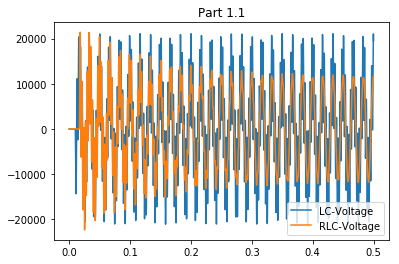

In [51]:
# Load Data from File for Part A
data = np.genfromtxt("PartA_data.ADF",delimiter='\t',skip_header=2,usecols=(0,1,2),unpack=True)
t_arr, LC_V, RLC_V = data

# Plot Data
plt.plot(t_arr,LC_V,label="LC-Voltage")
plt.plot(t_arr,RLC_V,label="RLC-Voltage")
plt.legend()
plt.title("Part 1.1")
plt.show()

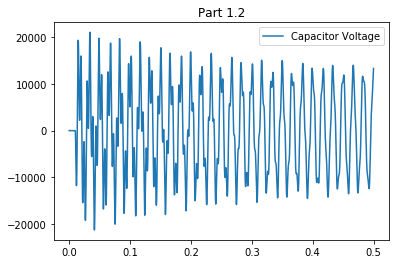

In [59]:
# Load Data from File for Part B
data = np.genfromtxt("PartB_data.ADF",delimiter='\t',skip_header=2,usecols=(0,1),unpack=True)
t_arr, VCAP = data

# Plot Data
plt.plot(t_arr,VCAP,label="Capacitor Voltage")
plt.legend()
plt.title("Part 1.2")
plt.show()

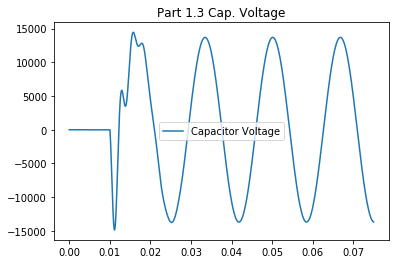

In [73]:
# Load Data from File for Part C
data = np.genfromtxt("PartC_data.ADF",delimiter='\t',skip_header=2,usecols=(0,1),unpack=True)
t_arr, VCAP= data

# Plot Data
plt.plot(t_arr,VCAP,label="Capacitor Voltage")
plt.legend()
plt.title("Part 1.3 Cap. Voltage")
plt.show()

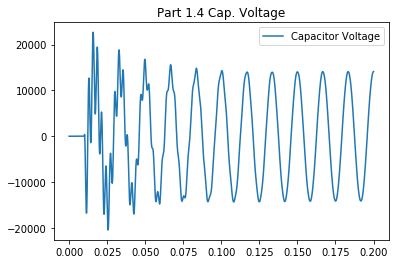

In [74]:
# Load Data from File for Part D
data = np.genfromtxt("PartD_data.ADF",delimiter='\t',skip_header=2,usecols=(0,1),unpack=True)
t_arr, VCAP= data

# Plot Data
plt.plot(t_arr,VCAP,label="Capacitor Voltage")
plt.legend()
plt.title("Part 1.4 Cap. Voltage")
plt.show()